# Lab Exercise :  River Basin Tradeoff Analysis

#### Maanav Jhatakia, 5551307

In this lab you will generate a tradeoff analysis across the different actors and water uses of the Nile for a suite of Pareto optimal reservoir operation policies. Namely, within the reservoirs located in Ethiopia, Sudan and Egypt.  

In [1]:
# Importing required packages
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm
from IPython.display import Image

# We need to give permission for connecting to our drive files
from google.colab import drive
#drive.mount('/content/drive')

# Copying the files from our drive folder. The folder name after ../MyDrive/ must match
#!cp /content/drive/MyDrive/water_systems -r /content

from water_systems.model_nile import ModelNile
from water_systems import plotter


/opt/anaconda3/envs/gds/lib/python3.8/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


## Nile River Basin model

In this case, we apply the modeling approach used by [Sari et.al. 2022](https://repository.tudelft.nl/islandora/object/uuid%3Aba09fa13-5331-446c-bf5e-48f6a29042ca?collection=education).  The problem, however, can be framed differently depending on the perspective of a country or a group of stakeholders. From Egypt's and Sudan's perspective, the goal is to minimize water shortages, whereas for Ethiopia, the priority is to maximize hydropower generation from the GERD. Therefore, no single objective formulation can maximize performance across all actors.  Due to the conflicting interests of the three countries, we use a many objective optimization problem formulation to find the **Pareto-optimal set**, where one objective cannot improve performance without degrading performance in one or more objectives.  

We define six objectives for the problem: 

* Minimize average annual water shortage for Egypt and for Sudan during the 
simulation horizon of 2022-2042.

*  Minimize the deficit of a month with the 90$^{th}$ percentile worst deficit. This objective denotes high risk aversion by minimizing the deficit for a catastrophic month for Sudan and Egypt. 
* Minimize the frequency of months when the water level in the High Aswan Dam (HAD) falls below the minimum hydroenergy production level. This objective reflects Egypt's hydropower generation goals.
* Maximize hydropower production Ethiopia desires to maximize the hydroenergy they produced from the GERD. Objectives are summarised in the table below. 


Country  | Objective     |Aggregation level| Unit    |Direction|
---------|---------------|-----------------|---------|---------|
Egypt    | Demand deficit| Annual average  | BCM/year|minimize |
Egypt    | Demand deficit| 90th percentile worst month|BCM/month|minimize
Egypt    | HAD level reliability| Frequency over 20 years| percent | minimize|
Sudan|Demand deficit| Annual average|BCM/month|minimize|
Sudan|Demand deficit| 90 th percentile worst month| BCM/month| minimize|
Ethiopia| Hydropower generation|Annual average|TWh/year|maximize|


To find the mult-reservoir, multi-objective control policy for the Nile system, we use **Evolutionary Multi-objective Direct Policy Search [(EMODPS)](https://ascelibrary.org/doi/10.1061/%28ASCE%29WR.1943-5452.0000570)** due to its flexibility to simultaneously find policies across many objectives, and its ability to overcome the dimensionality issues encountered when adding more states to the system (*i.e.* multiple reservoirs and streamflow scenarios). We first parameterize the control policy via nonlinear approximators, in this case, we use radial basis functions, due to their flexibility to find the control policy for multiple objectives.  The parameters of the radial basis functions are then optimized using a multiobjective evolutionary algorithm (MOEA) based on their performance across all the objectives of the system.  

A weighted Gaussian RBF is used to parameterize the release policy below. 

\begin{align}
        u^k_{τ} = u^k_{\theta}(Z_{\tau})\sum_{i=1} w_i^k\phi(Z_{\tau})
\end{align}

where $u_{\tau}^k$ is the $k^{th}$ release decision at month $\tau$ and $\theta$ is the parameter vector for the RBFs defined as $\theta=|c_{i,j}, b_{i,j}, w_i^k|$, $\bar{z}_{tau}$ is the input vector such that $\bar{z}_{tau}=|z_{\tau, 1},;;;, z_{\tau, m}|$.  The calculation of a single Gaussian RBF is shown in the equation below:


\begin{align}
        𝜑(\bar{Z}_{\tau})= exp(-\sum_{j=1}^m\frac{(z_{\tau,j}-c_{j,i})^2}{b^2_{j,i}})
\end{align}

 A visual summary of the EMODPS methodology within the [XLRM framework](https://www.rand.org/pubs/monograph_reports/MR1626.html) is provided below.

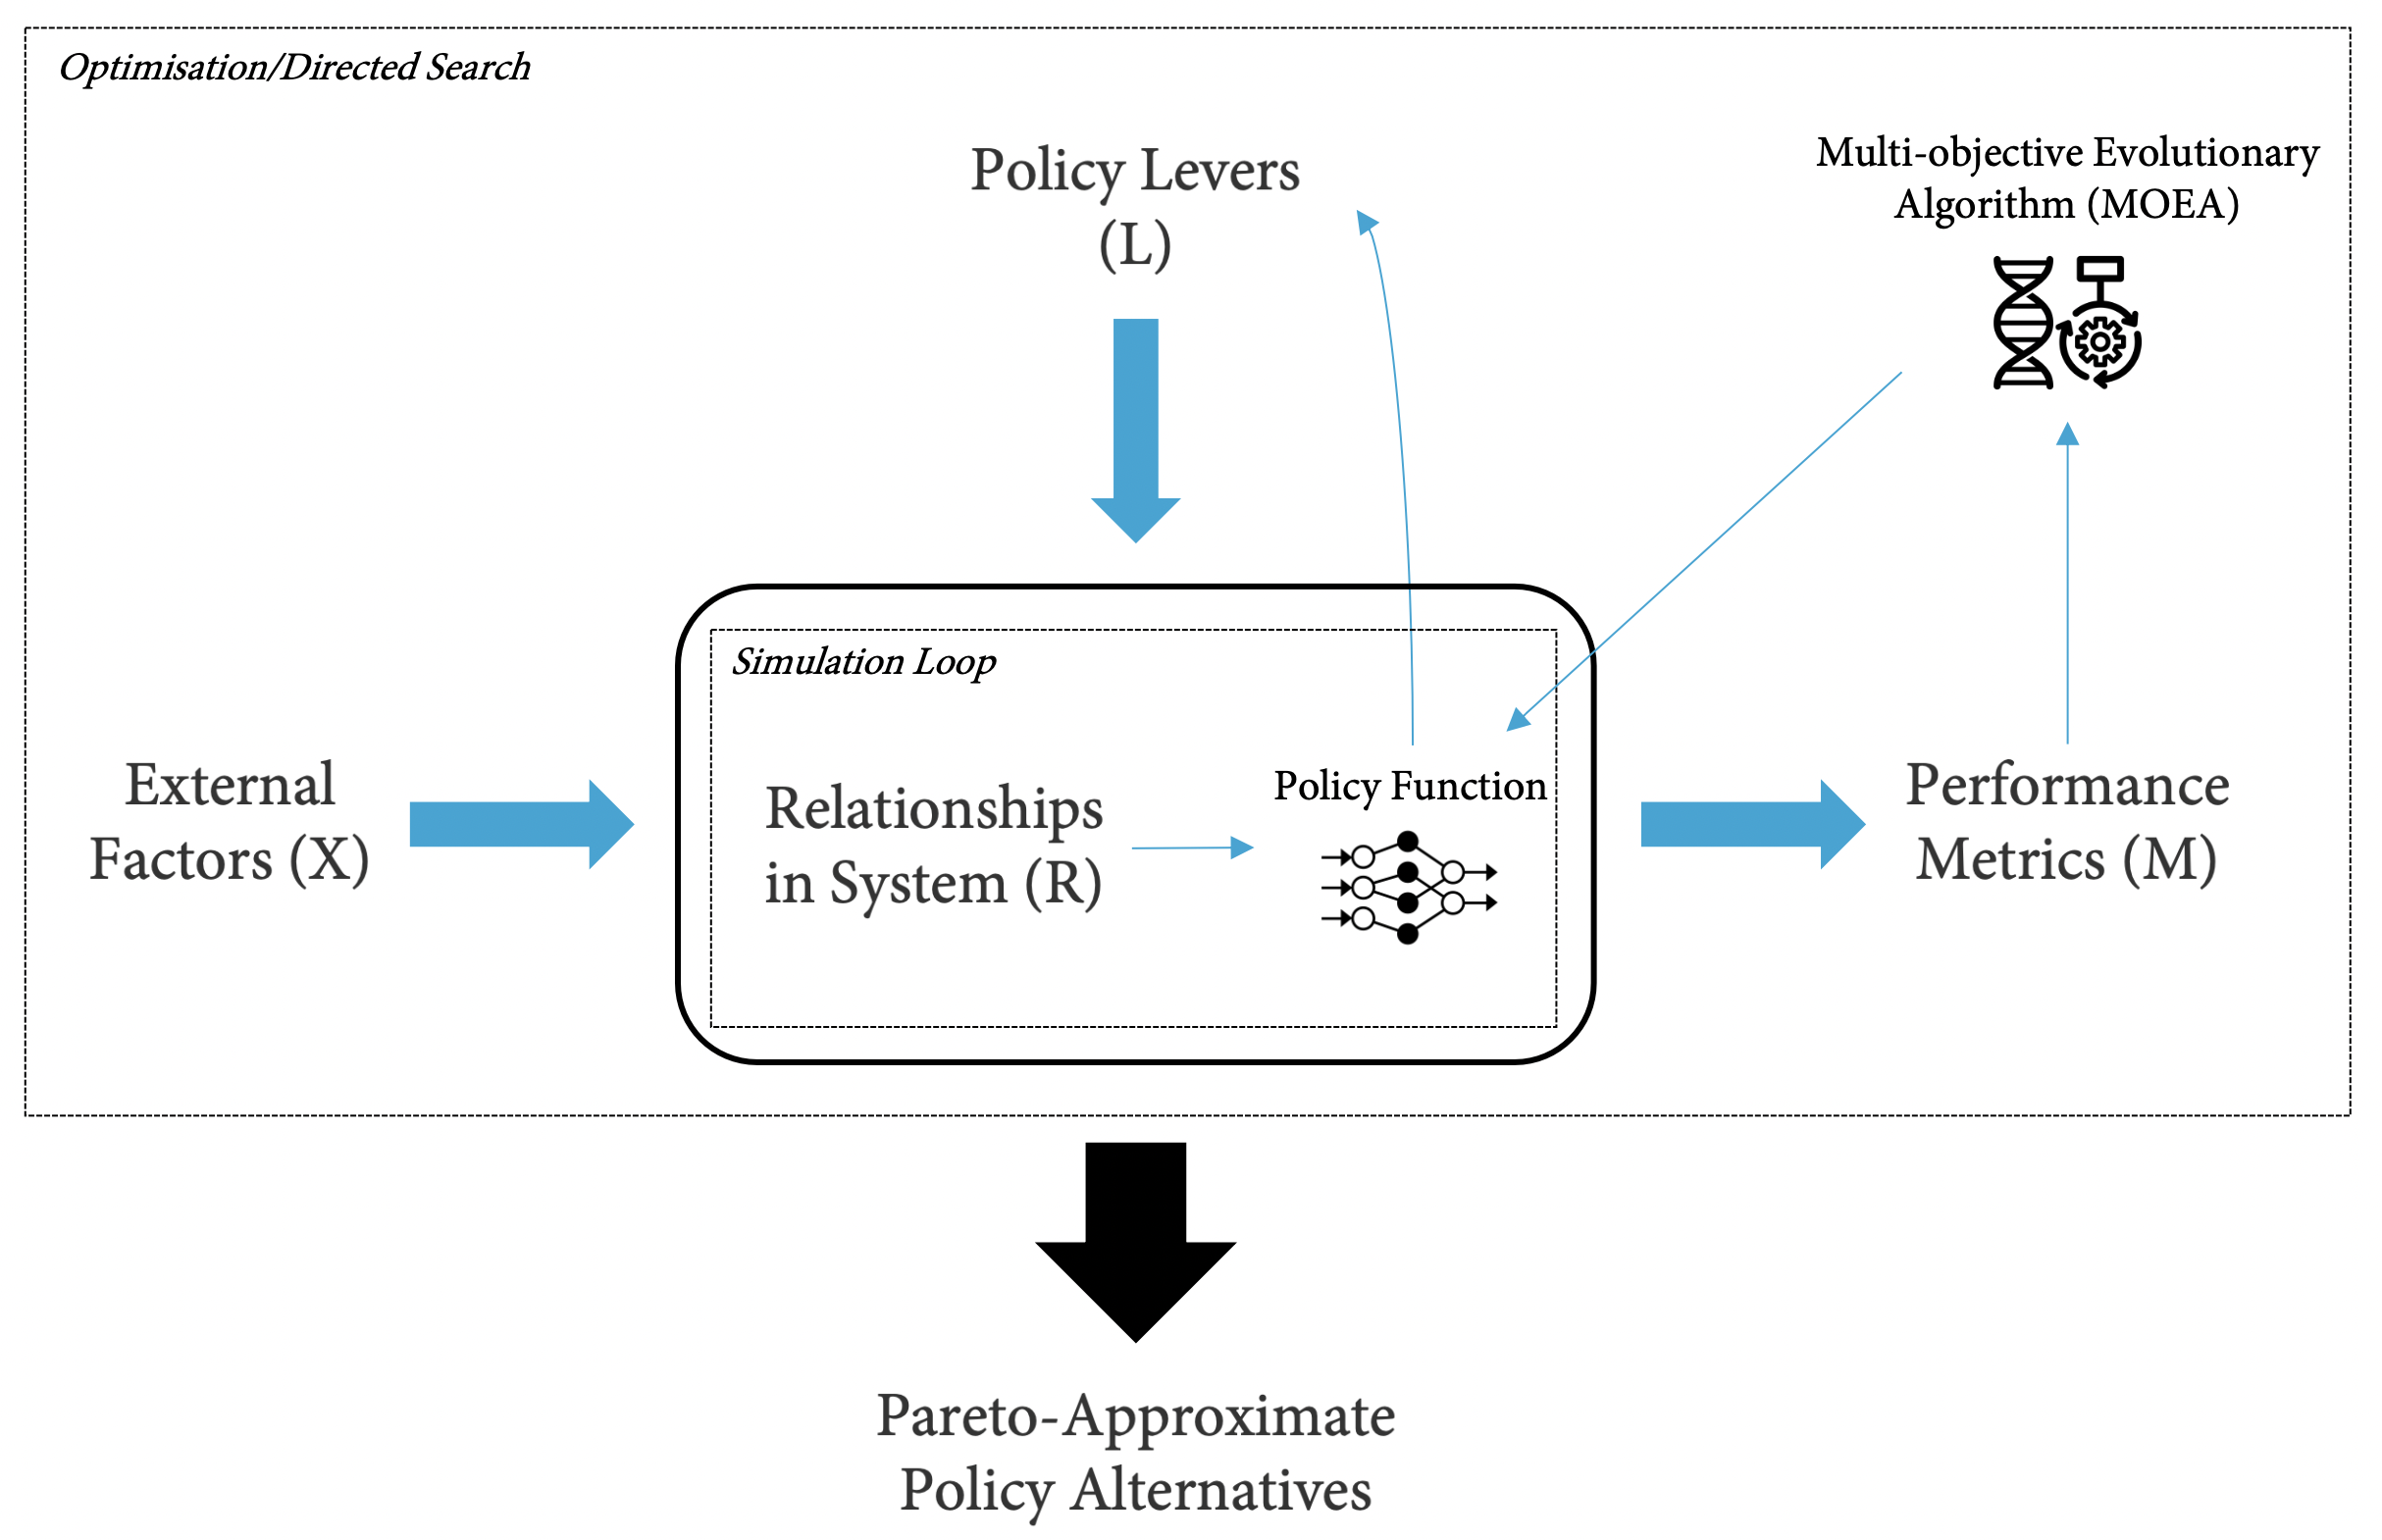

In [2]:
Image(filename='water_systems/readme_images/EMODPS_summary.png')

### Part 1. Pareto optimal tradeoffs across multiple conflicting water uses in the Nile River Basin

By running the code snipet below you will find the Pareto-optimal set of solutions. The dataframe is organized in columns which include the decision variables (values assigned to free parameters of the policy function) and the last six columns of the dataframe are the corresponding objective values.  Each row in the dataframe is a different Pareto-optimal policy. 

In [3]:
opt_results = pd.read_csv("water_systems/baseline_results.csv").drop(columns="Unnamed: 0")
opt_results.head()

,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v160,v161,v162,v163,egypt_irr,egypt_90,egypt_low_had,sudan_irr,sudan_90,ethiopia_hydro
0,0.082993,0.811609,0.463100,0.292359,0.279911,0.848383,-0.595641,0.134243,0.325801,0.030051,...,0.598760,0.617328,0.903964,0.063729,6.687976,1.525420,0.004167,0.002289,0.000000,14.640650
1,0.015787,0.809545,0.927957,0.311354,0.286745,0.854163,-0.590347,0.464409,0.317463,0.029033,...,0.189810,0.618542,0.269902,0.871519,3.130912,0.747328,0.183333,0.952067,0.234347,12.567715
2,0.082993,0.811609,0.946431,0.292359,0.279911,0.848383,-0.586181,0.134243,0.325801,0.030051,...,0.598760,0.617328,0.903964,0.063729,6.128643,1.496204,0.029167,0.000000,0.000000,14.625402
3,0.014471,0.803036,0.949657,0.311288,0.275820,0.848383,-0.627287,0.167977,0.291462,0.100378,...,0.183201,0.618279,0.924576,0.141372,5.468128,1.075512,0.708333,0.185484,0.000000,15.002676
4,0.015787,0.869487,0.943521,0.311354,0.286745,0.856220,-0.590347,0.585532,0.317463,0.029033,...,0.189810,0.618542,0.270329,0.883693,5.128414,1.574623,0.004167,0.762147,0.000000,14.007736


We first split the results into policies and objective using the code below. Further, we inspect the summary statistics across objectives, using objectives.describe().

In [4]:
#last six columns are the objectives, splitting them from the set
policies, objectives = opt_results.iloc[:, :-6], opt_results.iloc[:, -6:]
objectives.columns = [
        "Egypt Irr. Deficit",
        "Egypt 90th Irr. Deficit",
        "Egypt Low HAD",
        "Sudan Irr. Deficit",
        "Sudan 90th Irr. Deficit",
        "Ethiopia Hydropower"
]
objectives.describe()

,Egypt Irr. Deficit,Egypt 90th Irr. Deficit,Egypt Low HAD,Sudan Irr. Deficit,Sudan 90th Irr. Deficit,Ethiopia Hydropower
count,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000
mean,3.983717,0.978327,0.257920,0.527701,0.104980,13.466072
std,1.082543,0.341012,0.223281,0.572047,0.256392,1.230052
min,1.785302,0.151996,0.000000,0.000000,0.000000,9.783139
25%,3.168426,0.719622,0.075000,0.110130,0.000000,12.783826
50%,3.798724,0.968214,0.191667,0.254711,0.000000,13.666322
75%,4.591378,1.220168,0.396875,0.841442,0.000000,14.447477
max,11.995087,3.089898,0.795833,3.244097,1.502507,15.222886


A popular visualization strategy for  trade-off analysis across many objectives are [parallel coordinates](https://ieeexplore.ieee.org/document/636793). With parallel coordinates, each vertical axis represents the values for a particular objective.  The direction of preference is fixed across all objectives such that a line on top of all axis would represent the 'ideal' solution.  If two lines cross, it indicates that a tradeoff was encountered, in other words, it denotes high performance in one objective and low performance in another objective.   

The code below generates the parallel coordinates for the objective values. This function is called with the objectives dataframe. 

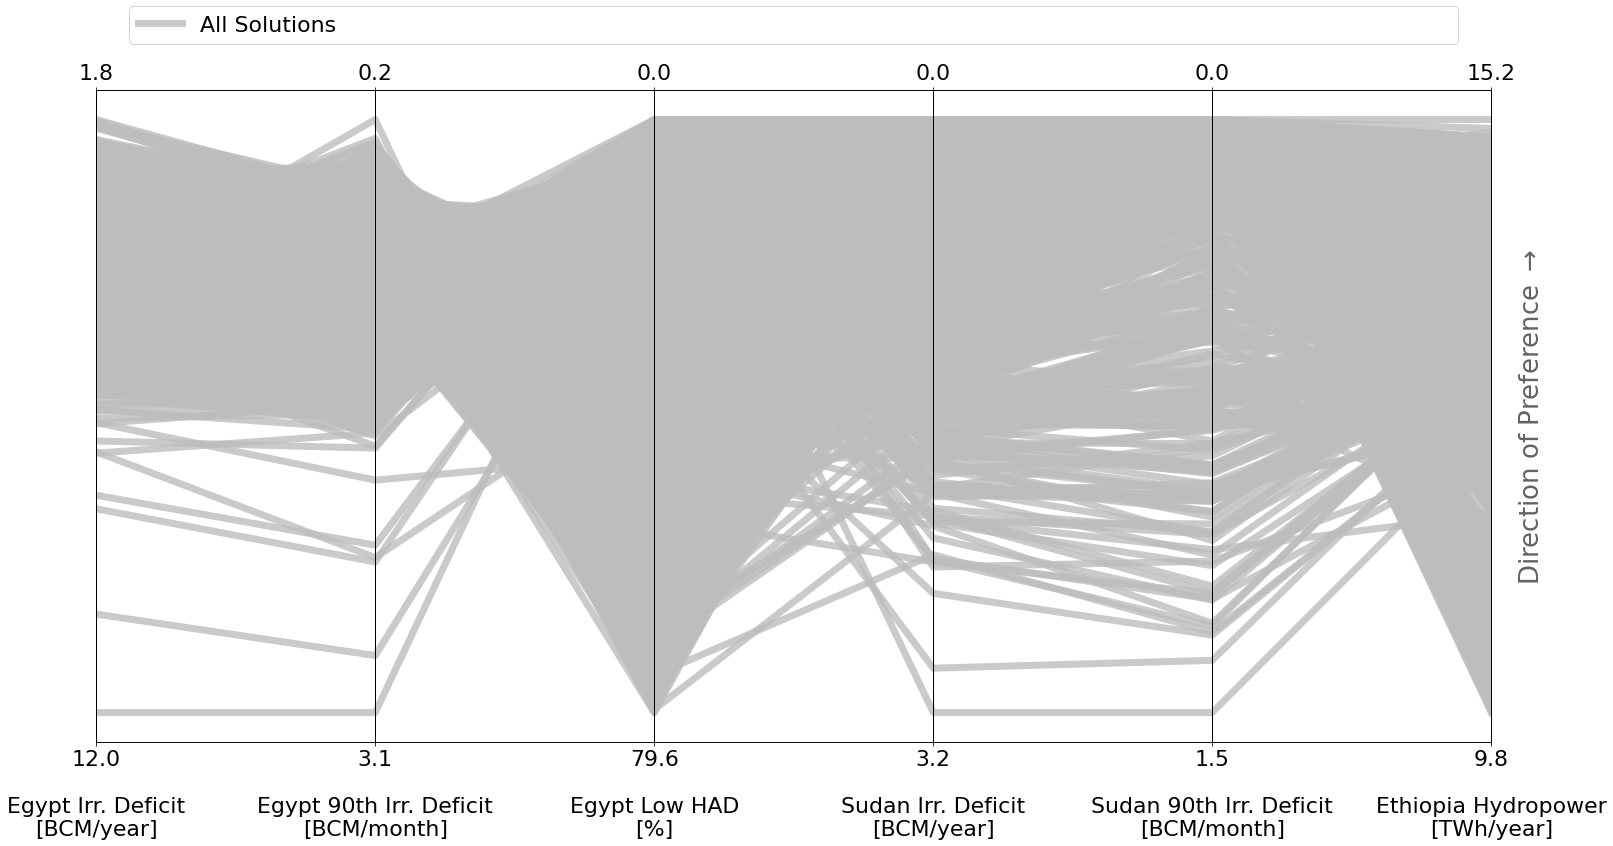

In [5]:
from water_systems.plotter import parallel_plots_many_policies

parallel_plots_many_policies(
    objectives,
    solution_indices=[],
    solution_names = []
)
plt.show()

### Part 2. Selecting and Analyzing Policies from the Pareto-optimal Set

Find the policies that yield the best performance across each of the Nile system's objectives (minimum value for minimization objectives and maximum value for maximization objectives). Give self-explanatory names to these policies and color-code them in the parallel coordinates plot.

Reflect on your findings and what they mean for the trade-offs between objectives. 

Tip:  To color-code specific policies from the Pareto-optimal set note that we have two empty lists as arguments for the parallel_plots_many_policies *solution_indices* and *solution_names*. It is possible to use these arguments to color-code the selected policies. For instance, the policy with index 100 is color-coded below.

In [6]:
objectives

,Egypt Irr. Deficit,Egypt 90th Irr. Deficit,Egypt Low HAD,Sudan Irr. Deficit,Sudan 90th Irr. Deficit,Ethiopia Hydropower
0,6.687976,1.525420,0.004167,0.002289,0.000000,14.640650
1,3.130912,0.747328,0.183333,0.952067,0.234347,12.567715
2,6.128643,1.496204,0.029167,0.000000,0.000000,14.625402
3,5.468128,1.075512,0.708333,0.185484,0.000000,15.002676
4,5.128414,1.574623,0.004167,0.762147,0.000000,14.007736
...,...,...,...,...,...,...
1135,5.910840,1.524070,0.041667,0.175973,0.000000,14.906745
1136,6.091426,1.466292,0.020833,0.292328,0.000000,15.049550
1137,5.780077,1.470808,0.012500,0.158914,0.000000,14.794841
1138,4.424983,1.107582,0.037500,0.124117,0.000000,11.311392


#### First, we need to find the preferred policies based on the criteria and direction above.

In [7]:
#locate the preferred policies of each objective based on the above criteria
pref_eth_hyd = objectives.loc[lambda objectives : objectives
                              ['Ethiopia Hydropower']== objectives['Ethiopia Hydropower'].max()] #1 policy
pref_egy_irr = objectives.loc[lambda objectives : objectives
                              ['Egypt Irr. Deficit']== objectives['Egypt Irr. Deficit'].min()] #1 policy
pref_egy_90 = objectives.loc[lambda objectives : objectives['Egypt 90th Irr. Deficit']== objectives
                             ['Egypt 90th Irr. Deficit'].min()] #1 policy
pref_egy_HAD = objectives.loc[lambda objectives : objectives['Egypt Low HAD']== objectives['Egypt Low HAD'].min()] #many
pref_sud_irr = objectives.loc[lambda objectives : objectives['Sudan Irr. Deficit']== 
                              objectives['Sudan Irr. Deficit'].min()] #many
pref_sud_90 = objectives.loc[lambda objectives : objectives['Sudan 90th Irr. Deficit']== 
                              objectives['Sudan 90th Irr. Deficit'].min()] #many

#note that pref_egy_HAD and pref_sud_irr seemed to have similar values in the pareto optimal set 
#as "Sudan 90th Irr. Deficit", so it was dropped from the concatenated dataset

#concatenate all created datasets of preferred policies above
frames = [pref_eth_hyd, pref_egy_irr, pref_egy_90,pref_egy_HAD, pref_sud_irr]
result = pd.concat(frames)


In [8]:
result

,Egypt Irr. Deficit,Egypt 90th Irr. Deficit,Egypt Low HAD,Sudan Irr. Deficit,Sudan 90th Irr. Deficit,Ethiopia Hydropower
740,4.154762,1.209638,0.358333,0.388640,0.000000,15.222886
1019,1.785302,0.537685,0.700000,1.747745,0.627059,13.677877
661,4.529007,0.151996,0.791667,0.311799,0.000000,13.168160
10,5.944767,1.499966,0.000000,0.000000,0.000000,13.800956
120,7.022576,1.554284,0.000000,0.155699,0.000000,14.818037
...,...,...,...,...,...,...
970,3.585685,1.079001,0.391667,0.000000,0.000000,14.253338
1006,5.433837,1.379749,0.041667,0.000000,0.000000,14.312792
1085,4.251268,1.157663,0.275000,0.000000,0.000000,14.223018
1092,3.135944,0.841835,0.725000,0.000000,0.000000,14.232924


##### There are a lot of policies - many are emerging from "Egypt Low HAD", "Sudan Irr. Deficit", and "Sudan 90th Irr. Deficit". To find optimal policies here, we should look at each individual set of preferred policies for these objectives. Given that many policies for these objective reach the preferred value, we should look at picking a policy from these that hit preferred values for either "Egypt Irr. Deficit" or "Ethiopia Hydropower", as these are the objectives that will provide the best insight into trade-offs later on. 

##### My process of finding the "preferred policies" for each of these objectives is to basically look at the statistics of these focused dataframes. By looking at the range of values for both the objectives of interest, I will use the objective with the highest range as the one to minimize (theoretically, a greater change in the optimized objective would amount to a smaller change in the non-optimized variable).

In [9]:
pref_egy_HAD.describe()

,Egypt Irr. Deficit,Egypt 90th Irr. Deficit,Egypt Low HAD,Sudan Irr. Deficit,Sudan 90th Irr. Deficit,Ethiopia Hydropower
count,21.000000,21.000000,21.0,21.000000,21.000000,21.000000
mean,5.480116,1.400969,0.0,0.559449,0.113308,13.838497
std,1.836222,0.454730,0.0,0.660370,0.265988,0.773188
min,3.266239,0.859281,0.0,0.000000,0.000000,12.202370
25%,4.527540,1.184442,0.0,0.098093,0.000000,13.483028
50%,5.106893,1.359616,0.0,0.189215,0.000000,13.782692
75%,5.944767,1.496094,0.0,0.908526,0.000000,14.396437
max,11.995087,3.089898,0.0,2.002937,0.966916,15.021484


In [10]:
print(pref_egy_HAD[pref_egy_HAD['Egypt Irr. Deficit'] == pref_egy_HAD['Egypt Irr. Deficit'].min()])

     Egypt Irr. Deficit  Egypt 90th Irr. Deficit  Egypt Low HAD  \
786            3.266239                 0.859281            0.0   

     Sudan Irr. Deficit  Sudan 90th Irr. Deficit  Ethiopia Hydropower  
786            2.002937                 0.966916            13.242326  


##### Therefore the preferred policy for "Egypt Low HAD" would be the policy with index 786. The same process is done with the other two objectives discussed above. 

In [11]:
pref_sud_irr.describe()

,Egypt Irr. Deficit,Egypt 90th Irr. Deficit,Egypt Low HAD,Sudan Irr. Deficit,Sudan 90th Irr. Deficit,Ethiopia Hydropower
count,51.000000,51.000000,51.000000,51.0,51.0,51.000000
mean,4.902569,1.310094,0.146732,0.0,0.0,14.112509
std,0.907050,0.181576,0.198297,0.0,0.0,0.688645
min,2.920616,0.841835,0.000000,0.0,0.0,12.202370
25%,4.309975,1.195583,0.022917,0.0,0.0,13.839168
50%,4.982007,1.307808,0.058333,0.0,0.0,14.312792
75%,5.541673,1.466751,0.181250,0.0,0.0,14.591435
max,6.404879,1.622936,0.725000,0.0,0.0,14.811893


In [12]:
print(pref_sud_irr[pref_sud_irr['Egypt Irr. Deficit'] == pref_sud_irr['Egypt Irr. Deficit'].min()])

     Egypt Irr. Deficit  Egypt 90th Irr. Deficit  Egypt Low HAD  \
558            2.920616                 0.918334         0.6875   

     Sudan Irr. Deficit  Sudan 90th Irr. Deficit  Ethiopia Hydropower  
558                 0.0                      0.0            14.310672  


In [13]:
pref_sud_90.describe()

,Egypt Irr. Deficit,Egypt 90th Irr. Deficit,Egypt Low HAD,Sudan Irr. Deficit,Sudan 90th Irr. Deficit,Ethiopia Hydropower
count,881.000000,881.000000,881.000000,881.000000,881.0,881.000000
mean,4.203910,1.039785,0.269783,0.281148,0.0,13.585396
std,1.078142,0.339486,0.232436,0.296453,0.0,1.315074
min,1.891632,0.151996,0.000000,0.000000,0.0,9.783139
25%,3.401583,0.788828,0.066667,0.080485,0.0,12.963520
50%,4.090078,1.053943,0.212500,0.170824,0.0,13.921214
75%,4.804112,1.273644,0.429167,0.382626,0.0,14.600980
max,11.995087,3.089898,0.795833,1.560430,0.0,15.222886


In [14]:
print(pref_sud_90[pref_sud_90['Egypt Irr. Deficit'] == pref_sud_90['Egypt Irr. Deficit'].min()])

     Egypt Irr. Deficit  Egypt 90th Irr. Deficit  Egypt Low HAD  \
743            1.891632                 0.545038       0.758333   

     Sudan Irr. Deficit  Sudan 90th Irr. Deficit  Ethiopia Hydropower  
743            0.949129                      0.0            13.926042  


In [15]:
result.describe

<bound method NDFrame.describe of       Egypt Irr. Deficit  Egypt 90th Irr. Deficit  Egypt Low HAD  \
740             4.154762                 1.209638       0.358333   
1019            1.785302                 0.537685       0.700000   
661             4.529007                 0.151996       0.791667   
10              5.944767                 1.499966       0.000000   
120             7.022576                 1.554284       0.000000   
...                  ...                      ...            ...   
970             3.585685                 1.079001       0.391667   
1006            5.433837                 1.379749       0.041667   
1085            4.251268                 1.157663       0.275000   
1092            3.135944                 0.841835       0.725000   
1108            4.353487                 1.253218       0.116667   

      Sudan Irr. Deficit  Sudan 90th Irr. Deficit  Ethiopia Hydropower  
740             0.388640                 0.000000            15.222886  
101

##### From the statistical description of the dataframe with the preferred policies, it shows that "Egypt Low HAD", "Sudan Irr. Deficit", and "Sudan 90th Irr. Deficit" (which all want to be minimized) show a large portion of the entries are very small values. The 25th and 50th percentiles of these objectives are relativly low with little to no change. Effectively, this means that in most policies, the value of these objectives will be low. 

##### We can also confirm this from the policies graph above detailing values for each of the policies - there is a large amount of clustering that occurs for these three objectives near the minimum end of their range. It shows that maybe these objectives aren't that representative of optimal policies, since they pretty much end up where the preferred values are. Note, however, that in the further isolated preferred policies, we should still remember that we want to minimize these values as much as possible without sacrificing anything else (i.e finding the Pareto optimal set).

##### Below, we also find the preferred policies for the other objectives in the "results_updated" dataframe.

In [16]:
frames_updated = [pref_eth_hyd, pref_egy_irr, pref_egy_90]
result_updated = pd.concat(frames_updated)

In [17]:
result_updated

,Egypt Irr. Deficit,Egypt 90th Irr. Deficit,Egypt Low HAD,Sudan Irr. Deficit,Sudan 90th Irr. Deficit,Ethiopia Hydropower
740,4.154762,1.209638,0.358333,0.388640,0.000000,15.222886
1019,1.785302,0.537685,0.700000,1.747745,0.627059,13.677877
661,4.529007,0.151996,0.791667,0.311799,0.000000,13.168160


##### To plot all of these policies, we get the following graph.

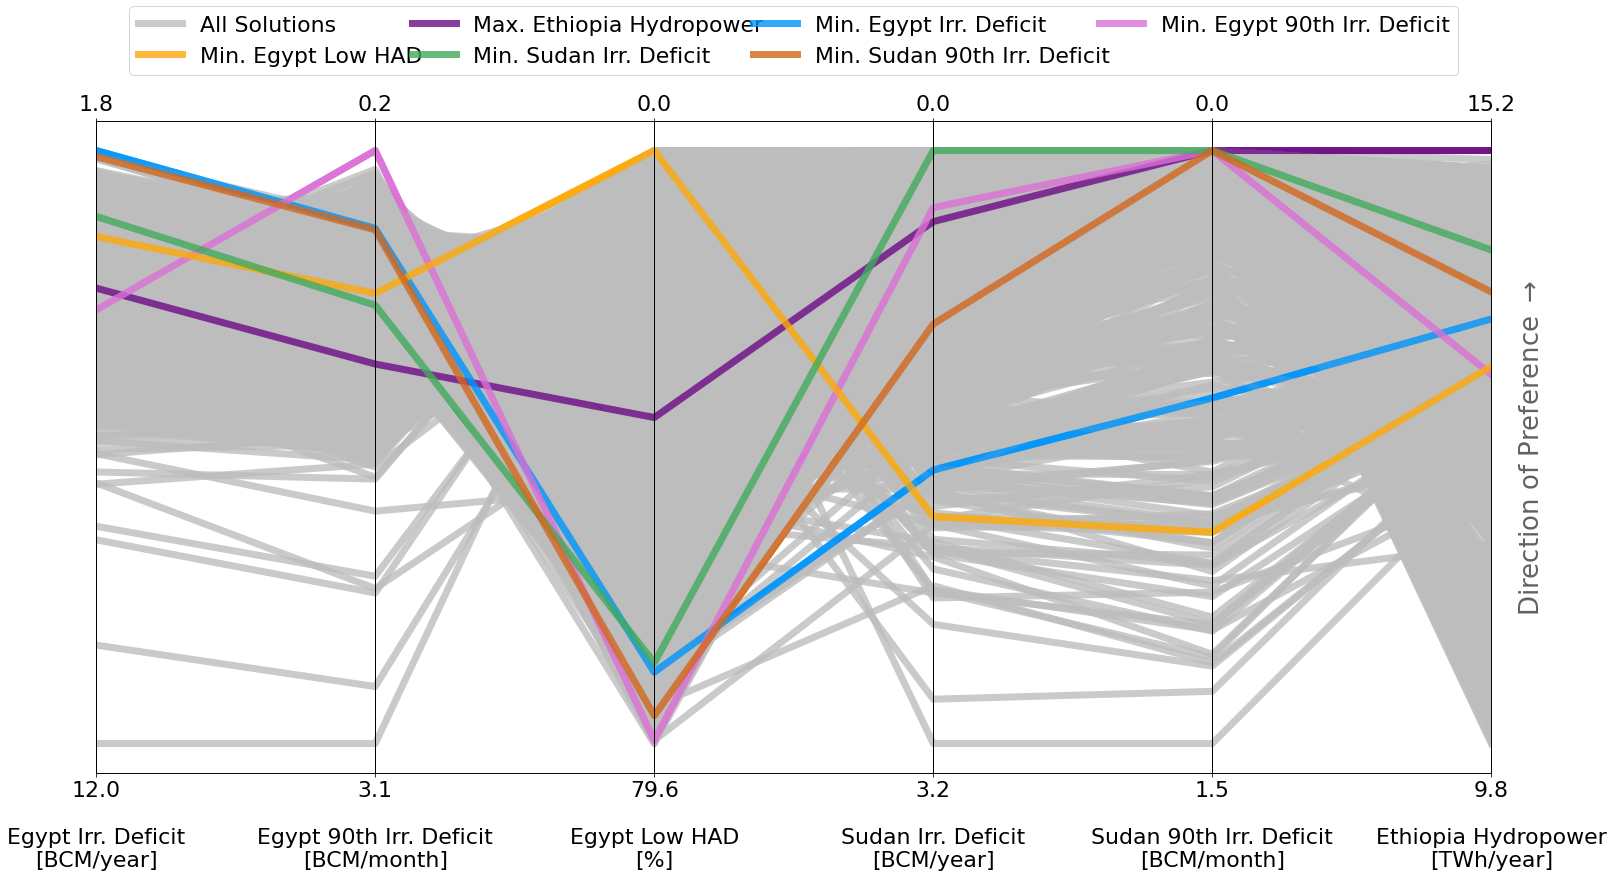

In [18]:
parallel_plots_many_policies(
    objectives,
    solution_indices=[740,1019,661, 786, 558, 743],
    solution_names = ['Max. Ethiopia Hydropower','Min. Egypt Irr. Deficit',
                      'Min. Egypt 90th Irr. Deficit','Min. Egypt Low HAD','Min. Sudan Irr. Deficit',
                     'Min. Sudan 90th Irr. Deficit']
)
plt.savefig('parcoor_plot_pareto_opt.png')
plt.show()

### Part 3: Defining compromise solutions across the system's objectives
Define two compromise solutions, this could be done by setting reliability thresholds across the different objectives. Please justify your selection. 

Plot these solutions along with the best policies across each objective.  Provide the parallel coordinates that include the full set of policies with the eight highlighted policies (*i.e.* the best performance across the six objectives and the two compromise solutions).  You will need to keep track of these policies for this week's assignment. You can use the code below to save your solutions as a csv file. 



##### To find the spread of the data (needed to find potential compromise solutions), I first looked at the variance of the original objectives dataframe.

In [19]:
objectives.var()

Egypt Irr. Deficit         1.171899
Egypt 90th Irr. Deficit    0.116289
Egypt Low HAD              0.049854
Sudan Irr. Deficit         0.327238
Sudan 90th Irr. Deficit    0.065737
Ethiopia Hydropower        1.513027
dtype: float64

##### Seeing that the scales of the objectives are different (for example, for Ethiopia Hydropower), I decided to normalize the dataframe to keep all values on the same scale. These would be utilized later on in determining a rank of importance.

In [20]:
objectives_copy = objectives.copy()

In [21]:
#normalization to help determine "order of preference"
objectives_copy = (objectives_copy - objectives_copy.min())/(objectives_copy.max()-objectives_copy.min())

In [22]:
objectives_copy.describe()

,Egypt Irr. Deficit,Egypt 90th Irr. Deficit,Egypt Low HAD,Sudan Irr. Deficit,Sudan 90th Irr. Deficit,Ethiopia Hydropower
count,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000
mean,0.215324,0.281266,0.324088,0.162665,0.069870,0.677041
std,0.106030,0.116073,0.280562,0.176335,0.170643,0.226123
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.135470,0.193208,0.094241,0.033948,0.000000,0.551623
50%,0.197205,0.277823,0.240838,0.078515,0.000000,0.713854
75%,0.274842,0.363583,0.498691,0.259376,0.000000,0.857455
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


##### In order to define compromise solutions, a logical step would be to find reliability coefficients for each of the objectives. Theoretically, the higher the reliability coefficient, the more consistent the objective values are in different scenarios (or different policies within the policy space). From there, I would be able to arrange these coefficients, where the lowest coefficient would be interpretted as the objective with the highest change in value.

##### However, calculating the reliability coefficients would be difficult as we don't have a specific "reference" or dependent value that we are measuring reliability against. Therefore, I decided to trying to find the spread of the data. I did this by multiplying the rank order of two criteria:
    
    - Descending rank of calculated variance (with 1 = the least resistant to change and 6 = most resistant to change
    
    - (Difference between normalized mean and targeted value preference [min or max value]) / standard deviation

##### The product of these ranks would determine a score. These scores would then be officially ranked, where the lowest value is the least resistent to change (i.e MOST "important") and the highest would most resistent to change (i.e LEAST "important"). This was done to determine an "order of importance" with which I will later find to scope down the proposed policies to the compromised policy choices. Gauging the level of variance or spread in the dataset to see whether a change in policy would render a significantly different value is a good way of finding dynamic objectives.

##### The final rankings determined are the following, from "MOST" important to "LEAST" important: 

    1. Ethiopia Hydropower
    2. Egypt Irr. Deficit
    3. Egypt 90th Irr. Deficit
    4. Sudan Irr. Deficit
    5. Egypt Low HAD
    6. Sudan 90th Irr. Deficit

##### Now that we have an order of importance for the objectives, we can start with a telescoping mechanism to, in rank order of importance, isolate the most preferable policies for a specific objective. Since we need to define two compromise policies, and noting the degree of skew and spread in many of the objectives, I set an incrementally increasing threshold weight as the importance of the objective drops. At the, we would have a smaller set of compromised solutions that we can choose from (if necessary).  

#####  The thresholds are as follows, in order:
    1. Ethiopia Hydropower, between [90th percentile and maximum value]
    2. Egypt Irr. Deficit, between [minimum value and 50th percentile]
    3. Egypt 90th Irr. Deficit, between [minimum value and 55th percentile]
    4. Sudan Irr. Deficit, between [minimum value and 60th percentile]
    5. Egypt Low HAD, between (minimum value and 65th percentile]
    6. Sudan 90th Irr. Deficit, between [minimum value and 70th percentile]

In [23]:
#max and min boundaries
eth_hydro_max = 15.222886
egy_irr_def_min = 1.785302
egy_90_irr_def_min = 0.151996
sud_irr_def_min = 0
egy_low_HAD_min = 0
sud_90_irr_def_min = 0

objectives_comp_df = objectives.copy()

#setting thresholds
objectives_comp_df = objectives_comp_df[objectives_comp_df['Ethiopia Hydropower'].between(
    objectives_comp_df['Ethiopia Hydropower'].quantile(0.90), eth_hydro_max)]

objectives_comp_df = objectives_comp_df[objectives_comp_df['Egypt Irr. Deficit'].between(
    egy_irr_def_min, objectives_comp_df['Egypt Irr. Deficit'].quantile(0.50))]

objectives_comp_df = objectives_comp_df[objectives_comp_df['Egypt 90th Irr. Deficit'].between(
    egy_90_irr_def_min, objectives_comp_df['Egypt 90th Irr. Deficit'].quantile(0.55))]

objectives_comp_df = objectives_comp_df[objectives_comp_df['Sudan Irr. Deficit'].between(
    sud_irr_def_min, objectives_comp_df['Sudan Irr. Deficit'].quantile(0.60))]

objectives_comp_df = objectives_comp_df[objectives_comp_df['Egypt Low HAD'].between(
    egy_low_HAD_min, objectives_comp_df['Egypt Low HAD'].quantile(0.65))]

objectives_comp_df = objectives_comp_df[objectives_comp_df['Sudan 90th Irr. Deficit'].between(
    sud_90_irr_def_min, objectives_comp_df['Sudan 90th Irr. Deficit'].quantile(0.70))]

In [24]:
objectives_comp_df

,Egypt Irr. Deficit,Egypt 90th Irr. Deficit,Egypt Low HAD,Sudan Irr. Deficit,Sudan 90th Irr. Deficit,Ethiopia Hydropower
7,4.565099,1.188678,0.483333,0.159598,0.0,15.014666
16,4.977603,1.219944,0.220833,0.216315,0.0,15.019474
68,4.684850,1.214494,0.237500,0.253134,0.0,15.035113
70,4.324709,1.124946,0.325000,0.238179,0.0,14.986529
125,4.801812,1.114639,0.429167,0.243696,0.0,15.036884
233,4.733709,1.221755,0.404167,0.047687,0.0,14.928678
285,5.055152,1.224634,0.325000,0.038402,0.0,14.954955
345,4.721938,1.205190,0.479167,0.194819,0.0,15.028197
491,4.764942,1.211261,0.404167,0.177514,0.0,15.041019
629,4.102485,1.169777,0.379167,0.115608,0.0,14.965463


##### Plotting the solutions that we have gotten so far, we get the following pair coordinate plot.

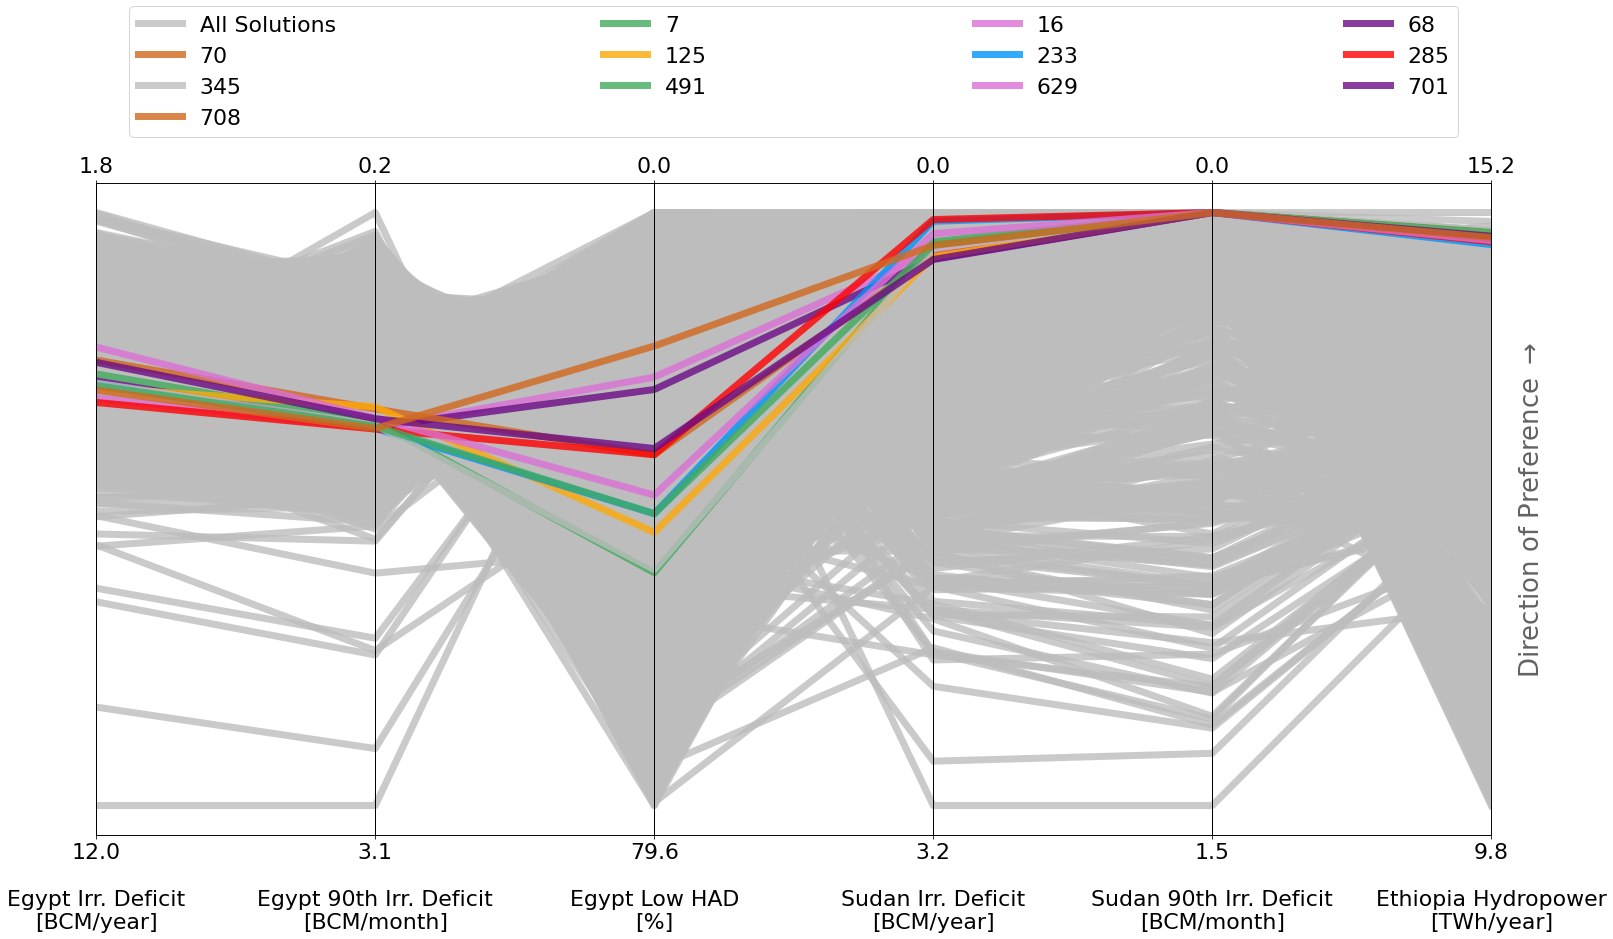

In [25]:
parallel_plots_many_policies(
    objectives,
    solution_indices=[7,16,68,70,125,233,285,345,491,629,701,708],
    solution_names = ['7','16','68','70','125','233','285','345','491','629','701','708']
)
plt.show()

##### The plot shows that many of the policies are producing similar values in the most important objectives, with much more variance occuring in "Egypt Low HAD" and "Sudan Irr. Deficit". Several of the policies, when placed into a preference table detailing the order of which policies each objective would prefer,seemed to have very polizaring performances i.e having very high performance in some objective while having very low preference in others. None had a definitive place in the 'middle ground" amongst all objectives. Therefore, to find two compromising policies, I decided to categorize these objectives by location to find policies that, on average, benefit all three countries (Egypt, Sudan, and Ethiopia) similarly. 

##### I also took into account the original order of importance that was given to the objectives. Policy 70 was one choice. While it was in the lower-center of the preference for "Ethiopia Hydropower" and "Sudan Irr. Deficit", the values for these were relatively consistent in the updated list of policies above. Thus, differences for these objective's values from the optimal value would not be much. However, for Egypt's objectives, performance was above average (yet not the best possible). Thus, it was chosen as one of the compromise policies. Second, Policy 345 was chosen. Policy 345 provides a compromise for Egypt; while it secures water for irrigation with a relatively high preferred policy, policy 345 is of much lower preference for its "Egypt Low HAD" objective. Objectives for Ethiopia and Sudan also were center in the ordered list of preferred policies. 

##### Graphing each objective's optimal policy with the chosen compromise policy, we get the following:

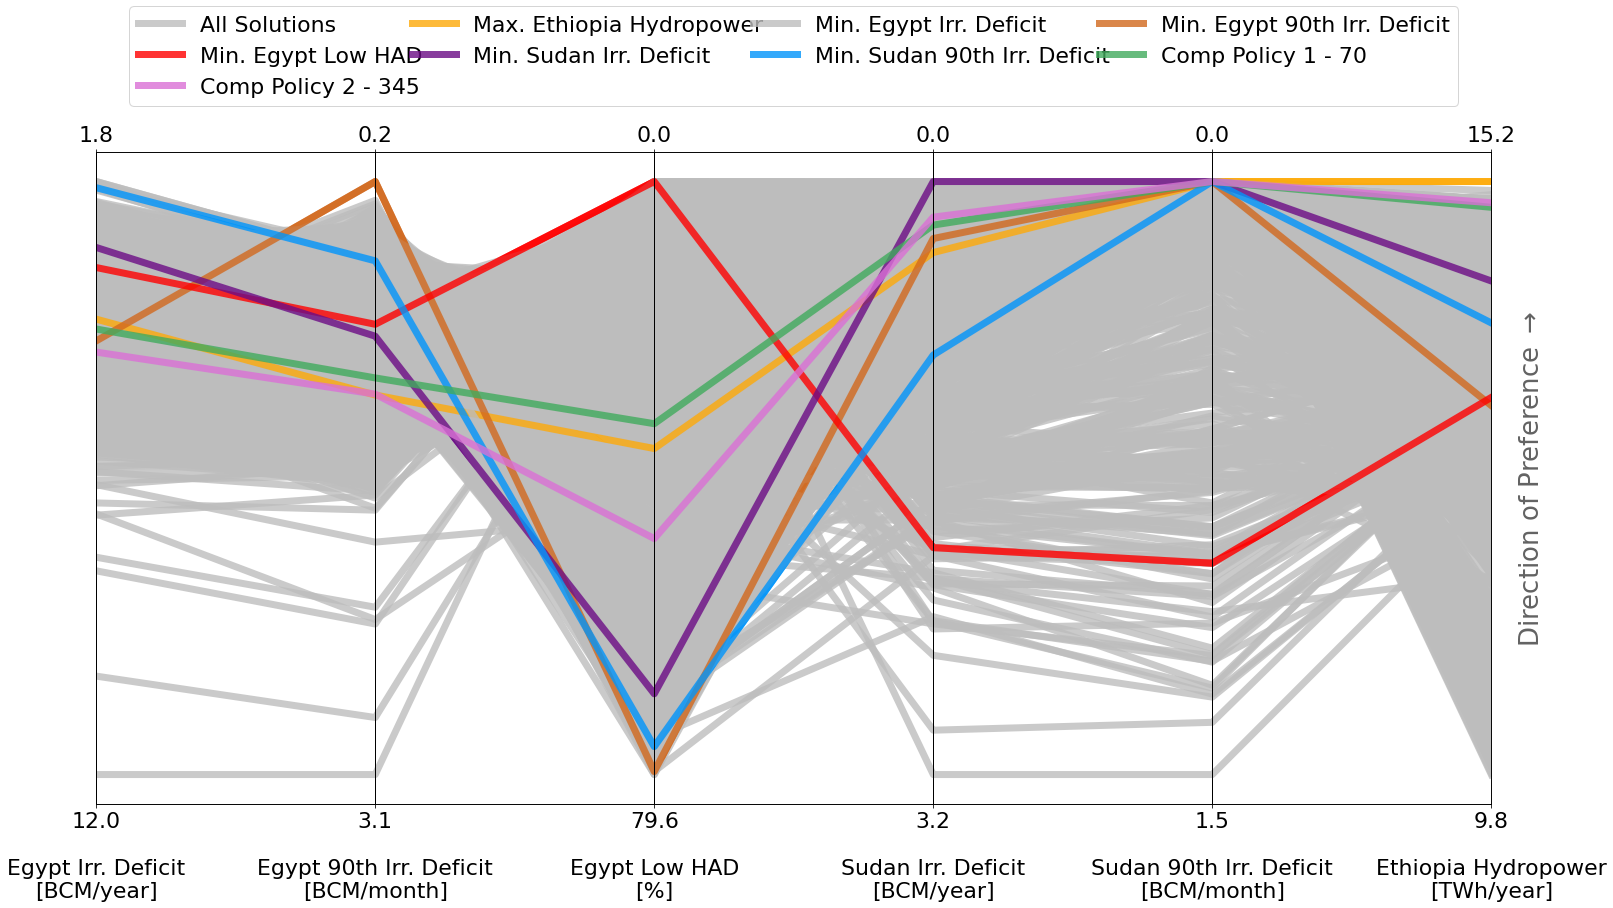

In [26]:
parallel_plots_many_policies(
    objectives,
    solution_indices=[740,1019,661, 786, 558, 743, 70, 345],
    solution_names = ['Max. Ethiopia Hydropower','Min. Egypt Irr. Deficit',
                      'Min. Egypt 90th Irr. Deficit','Min. Egypt Low HAD','Min. Sudan Irr. Deficit',
                     'Min. Sudan 90th Irr. Deficit','Comp Policy 1 - 70','Comp Policy 2 - 345']
)
plt.savefig('parcoor_plot_pareto_opt_with_comp.png')
plt.show()

##### Finally, we'll save the policy set for further analysis.

In [27]:
solution_indices = [740,1019,661, 786, 558, 743, 70, 345] # Input the indices for your policy selection
solution_names = ['Max. Ethiopia Hydropower','Min. Egypt Irr. Deficit',
                      'Min. Egypt 90th Irr. Deficit','Min. Egypt Low HAD','Min. Sudan Irr. Deficit',
                     'Min. Sudan 90th Irr. Deficit','Comp Policy 1 - 70','Comp Policy 2 - 345'] # Input explanatory names for your policy selection

policies_for_exploration = policies.loc[solution_indices, :]
policies_for_exploration["name"] = solution_names
policies_for_exploration.to_csv(
    "water_systems/policies_for_exploration.csv",
    index=False
  )